# Find worst cases 

\begin{equation}
\begin{array}{rl}
    \mathcal{F}_L =& \dfrac{4 K I H r}{Q_{in}(1+f)}\\
    u_{c} =& \dfrac{-KI\mathcal{F}_L}{\theta \left(\mathcal{F}_L+1\right)}\\
    \tau =& -\dfrac{r}{|u_{c}|}\\
    C_{\tau,{\rm decay}}=& C_0 \exp{\left(-\lambda \tau \right)}\\
    C_{\tau,{\rm filtr}}=& C_0 \exp{\left(-k_{\rm att} \tau \right)}\\
    C_{\tau,{\rm dilut}} =& C_{in} \left( \dfrac{Q_{in}}{u_c \Delta y \Delta z} \right)\\
    C_{\tau,{\rm both}} =& \dfrac{C_{\rm in}Q_{\rm in}}{u_c \Delta y H \theta} \exp{\left(-\lambda\dfrac{r}{|u_c|}\right)}
\end{array}
\end{equation}

In [1]:
%reset -f
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from os import system
import os
from matplotlib.gridspec import GridSpec 
from drawStuff import *

import jupypft.attachmentRateCFT as CFT
import jupypft.plotBTC as BTC

''' GLOBAL CONSTANTS '''
PI = 3.141592
THETA = 0.35

In [2]:
def flowNumber():
    return (4.0*K*I*H*r) / (Qin*(1+f))

def uChar():
    '''Interstitial water velocity'''
    return -(K*I*flowNumber())/(THETA*(flowNumber() + 1))

def tChar():
    return -r/uChar()

def cDecay():
    return C0 * np.exp(-decayRate * tChar())

def cAttach():
    return C0 * np.exp(-attchRate * tChar())

def cDilut():
    return (C0 * Qin) / (-uChar() * delY * delZ * THETA)

def cBoth():
    return (C0 * Qin) / (-uChar() * delY * delZ * THETA) * np.exp(-decayRate * tChar())

def cTrice():
    return (C0 * Qin) / (-uChar() * delY * delZ * THETA) * np.exp(-(decayRate+attchRate) * tChar())

def findSweet():
    deltaConc = np.abs(cBoth() - np.max(cBoth()))
    return np.argmin(deltaConc)

def findSweet2():
    deltaConc = np.abs(cTrice() - np.max(cTrice()))
    return np.argmin(deltaConc)

In [3]:
K = 10**-2
Qin = 0.24/86400
f = 10
H = 20
r = 40
I = 0.001
C0 = 1.0
qabs = np.abs(uChar()*THETA)

kattDict = dict(
    dp = 1.0E-7,
    dc = 2.0E-3,
    q = qabs,
    theta = THETA,
    visco = 0.0008891,
    rho_f = 999.79,
    rho_p = 1050.0,
    A = 5.0E-21,
    T = 10. + 273.15,
    alpha = 0.01)

decayRate = 3.5353E-06
attchRate,_ = CFT.attachmentRate(**kattDict)
delY,delZ = 1.35,H

In [4]:
print("Nondim Flow  = {:.2E}".format(flowNumber()))
print("Charac. Vel  = {:.2E} m/s".format(uChar()))
print("Charac. time = {:.2E} s".format(tChar()))

Nondim Flow  = 1.05E+03
Charac. Vel  = -2.85E-05 m/s
Charac. time = 1.40E+06 s


In [5]:
print("Rel concenc. due decay = {:.2E}".format(cDecay()))
print("Rel conc. due dilution = {:.2E}".format(cDilut()))
print("Rel conc. due attachmt = {:.2E}".format(cAttach()))
print("Rel conc. due both eff = {:.2E}".format(cBoth()))
print("Rel conc. due three ef = {:.2E}".format(cTrice()))

Rel concenc. due decay = 7.05E-03
Rel conc. due dilution = 1.03E-02
Rel conc. due attachmt = 4.42E-05
Rel conc. due both eff = 7.26E-05
Rel conc. due three ef = 3.21E-09


## v.1

## PLOTRAN SIMULATION RESULTS

# v.2

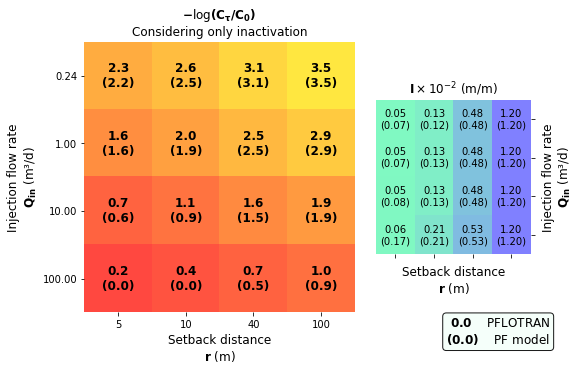

In [6]:
K = 10**-2
H = 20
f = 10
C0 = 1.0
decayRate = 3.5353E-06

Qin_array = np.array([0.24,1.0,10.0,100.])/86400.
rarray = np.array([5.,10.,40.,100.])
Iarray = 10**np.linspace(-5,0,num=100)

Ci = np.zeros([len(rarray),len(Qin_array)])
Ii = np.zeros([len(rarray),len(Qin_array)])
FLi = np.zeros([len(rarray),len(Qin_array)])
I = Iarray

## Predictions 
for qi,Qin in enumerate(Qin_array):
    for ri,r in enumerate(rarray):
        i = findSweet()
        worstC = -np.log10(cBoth()[i])
        worstGradient = Iarray[i]
        worstFlowNumber = flowNumber()[i]
        
        Ci[ri,qi] = worstC
        Ii[ri,qi] = worstGradient
        FLi[ri,qi] = worstFlowNumber

## Pflotran results
minI = np.array([0.00046667, 0.0013    , 0.0048    , 0.012     , 0.00046667,
       0.0013    , 0.0048    , 0.012     , 0.00053333, 0.0013    ,
       0.0048    , 0.012     , 0.00056667, 0.0021    , 0.0053    ,
       0.012     ])

minC = np.array([2.2514572 , 2.62298917, 3.14213329, 3.51421485, 1.64182175,
       2.00913676, 2.52461269, 2.89537637, 0.74130696, 1.0754177 ,
       1.55071976, 1.90646243, 0.18705258, 0.39222131, 0.73428991,
       1.00387133])

PFLO_I = np.reshape(minI,Ii.shape).T
PFLO_C = np.reshape(minC,Ci.shape).T

## Build annotations
annot_C = [ [ "None" for y in range(len(Qin_array)) ] for x in range(len(rarray)) ]
annot_I = [ [ "None" for y in range(len(Qin_array)) ] for x in range(len(rarray)) ]

for qi,Qin in enumerate(Qin_array):
    for ri,r in enumerate(rarray):
        pflC,pflI = (0, PFLO_C[ri,qi]) [float(PFLO_C[ri,qi])>0.0] ,PFLO_I[ri,qi]*100
        zC,zI = (0, Ci[ri,qi]) [float(Ci[ri,qi])>0.0] , Ii[ri,qi]*100
        annot_C[ri][qi] = "{:.1f}\n({:.1f})".format(pflC,zC)
        annot_I[ri][qi] = "{:.2f}\n({:.2f})".format(pflI,zI)
        
#########

myLabels={"Title": { 0: r"$\bf{-\log (C_{\tau}/C_0)}$"+"\nConsidering only inactivation",
                     1: r"${\bf I} \times 10^{-2}$ (m/m)",
                     2: r"$\log(\mathcal{F}_L)$"},
          "Y": "Injection flow rate\n$\\bf{Q_{in}}$ (m³/d)",
          "X": "Setback distance\n$\\bf{r}$ (m)"}

fig, axs = plt.subplots(1,2,sharex=False, sharey=False,\
              figsize=(8,8),gridspec_kw={"width_ratios":[1.75,1],"hspace":0.04,"wspace":0.1}) 

font = dict(size=12)

ax = axs[0]
im = ax.imshow(PFLO_C.T,cmap="autumn",vmin=0,vmax=4,alpha=0.75)
#cbar = ax.figure.colorbar(im, ax=ax, orientation="horizontal",\
#                         shrink=0.75)

# We want to show all ticks...
ax.set_xticks(np.arange(len(rarray)))
ax.set_yticks(np.arange(len(Qin_array)))
# ... and label them with the respective list entries
ax.set_xticklabels(["{:.0f}".format(i) for i in rarray])
ax.set_yticklabels(["{:.2f}".format(i*86400) for i in Qin_array])

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=0, ha="center",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(Qin_array)):
    for j in range(len(rarray)):
        text = ax.text(j, i, annot_C[j][i],
                       ha="center", va="center", color="k",
                       fontweight="bold",fontsize=12,
                       bbox= dict(facecolor='w', alpha=0,edgecolor='w'))

ax.set_title(myLabels["Title"][0],fontdict=font)              
############################
ax = axs[1]
im = ax.imshow(PFLO_I.T*100,vmin = 0, vmax = 1, cmap="winter_r",alpha=0.5)
#cbar = ax.figure.colorbar(im, ax=ax, orientation="horizontal",\
#                         shrink=0.75)

# We want to show all ticks...
ax.set_xticks(np.arange(len(rarray)))
ax.set_yticks(np.arange(len(Qin_array)))
# ... and label them with the respective list entries
ax.set_xticklabels(["".format(i) for i in rarray])
ax.set_yticklabels(["" for i in Qin_array])

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=0, ha="center",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(Qin_array)):
    for j in range(len(rarray)):
        text = ax.text(j, i, annot_I[j][i],
                       ha="center", va="center", color="k",
                       fontweight="normal",fontsize=10,
                       bbox= dict(facecolor='w', alpha=0,edgecolor='w'))

ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.set_title(myLabels["Title"][1],fontdict=font)
    
# Turn spines off and create white grid.
for ax in axs:
    for edge, spine in ax.spines.items():
        spine.set_visible(False)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)
    ax.set_xlabel(myLabels["X"],fontdict=font)
    ax.set_ylabel(myLabels["Y"],fontdict=font)


# Legend
import matplotlib.lines as mlines

legend = r"$\bf{0.0}$" + "    PFLOTRAN"+"\n"\
       + r"$\bf{(0.0)}$" + "    PF model"
ax.text(4,5.5,legend,fontsize=12,
        ha='right',va='center',weight='normal',\
        bbox=dict(boxstyle='round', facecolor='mintcream', alpha=0.90))

plt.savefig("HeatmapComplete_OnlyInactivation.png",dpi=200,bbox_inches='tight', pad_inches=0)

plt.show()

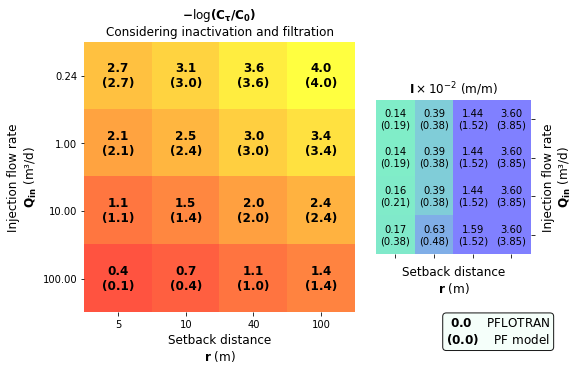

In [7]:
K = 10**-2
H = 20
f = 10
C0 = 1.0
decayRate = 3.5353E-06

Qin_array = np.array([0.24,1.0,10.0,100.])/86400.
rarray = np.array([5.,10.,40.,100.])
Iarray = 10**np.linspace(-5,0,num=100)

Ci = np.zeros([len(rarray),len(Qin_array)])
Ii = np.zeros([len(rarray),len(Qin_array)])
FLi = np.zeros([len(rarray),len(Qin_array)])
I = Iarray

## Predictions 
for qi,Qin in enumerate(Qin_array):
    for ri,r in enumerate(rarray):
        i = findSweet2()
        worstC = -np.log10(cTrice()[i])
        worstGradient = Iarray[i]
        worstFlowNumber = flowNumber()[i]
        
        Ci[ri,qi] = worstC
        Ii[ri,qi] = worstGradient
        FLi[ri,qi] = worstFlowNumber

## Pflotran results

minI = np.array([0.0014, 0.0039, 0.0144, 0.036 , 0.0014, 0.0039, 0.0144, 0.036 ,
       0.0016, 0.0039, 0.0144, 0.036 , 0.0017, 0.0063, 0.0159, 0.036 ])

minC = np.array([2.70966103, 3.09070854, 3.61937381, 3.99433636, 2.0934136 ,
       2.47294713, 3.00034689, 3.37487213, 1.13490091, 1.49712873,
       2.00931935, 2.37863042, 0.39427172, 0.66484608, 1.08376174,
       1.41433393])

PFLO_I = np.reshape(minI,Ii.shape).T
PFLO_C = np.reshape(minC,Ci.shape).T

## Build annotations
annot_C = [ [ "None" for y in range(len(Qin_array)) ] for x in range(len(rarray)) ]
annot_I = [ [ "None" for y in range(len(Qin_array)) ] for x in range(len(rarray)) ]

for qi,Qin in enumerate(Qin_array):
    for ri,r in enumerate(rarray):
        pflC,pflI = (0, PFLO_C[ri,qi]) [float(PFLO_C[ri,qi])>0.0] ,PFLO_I[ri,qi]*100
        zC,zI = (0, Ci[ri,qi]) [float(Ci[ri,qi])>0.0] , Ii[ri,qi]*100
        annot_C[ri][qi] = "{:.1f}\n({:.1f})".format(pflC,zC)
        annot_I[ri][qi] = "{:.2f}\n({:.2f})".format(pflI,zI)
        
#########

myLabels={"Title": { 0: r"$\bf{-\log (C_{\tau}/C_0)}$" + "\nConsidering inactivation and filtration",
                     1: r"${\bf I} \times 10^{-2}$ (m/m)",
                     2: r"$\log(\mathcal{F}_L)$"},
          "Y": "Injection flow rate\n$\\bf{Q_{in}}$ (m³/d)",
          "X": "Setback distance\n$\\bf{r}$ (m)"}

fig, axs = plt.subplots(1,2,sharex=False, sharey=False,\
              figsize=(8,8),gridspec_kw={"width_ratios":[1.75,1],"hspace":0.04,"wspace":0.1}) 

font = dict(size=12)

ax = axs[0]
im = ax.imshow(PFLO_C.T,cmap="autumn",vmin=0,vmax=4,alpha=0.75)
#cbar = ax.figure.colorbar(im, ax=ax, orientation="horizontal",\
#                         shrink=0.75)

# We want to show all ticks...
ax.set_xticks(np.arange(len(rarray)))
ax.set_yticks(np.arange(len(Qin_array)))
# ... and label them with the respective list entries
ax.set_xticklabels(["{:.0f}".format(i) for i in rarray])
ax.set_yticklabels(["{:.2f}".format(i*86400) for i in Qin_array])

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=0, ha="center",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(Qin_array)):
    for j in range(len(rarray)):
        text = ax.text(j, i, annot_C[j][i],
                       ha="center", va="center", color="k",
                       fontweight="bold",fontsize=12,
                       bbox= dict(facecolor='w', alpha=0,edgecolor='w'))

ax.set_title(myLabels["Title"][0],fontdict=font)              
############################
ax = axs[1]
im = ax.imshow(PFLO_I.T*100,vmin = 0, vmax = 1, cmap="winter_r",alpha=0.5)
#cbar = ax.figure.colorbar(im, ax=ax, orientation="horizontal",\
#                         shrink=0.75)

# We want to show all ticks...
ax.set_xticks(np.arange(len(rarray)))
ax.set_yticks(np.arange(len(Qin_array)))
# ... and label them with the respective list entries
ax.set_xticklabels(["".format(i) for i in rarray])
ax.set_yticklabels(["" for i in Qin_array])

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=0, ha="center",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(Qin_array)):
    for j in range(len(rarray)):
        text = ax.text(j, i, annot_I[j][i],
                       ha="center", va="center", color="k",
                       fontweight="normal",fontsize=10,
                       bbox= dict(facecolor='w', alpha=0,edgecolor='w'))

ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.set_title(myLabels["Title"][1],fontdict=font)
    
# Turn spines off and create white grid.
for ax in axs:
    for edge, spine in ax.spines.items():
        spine.set_visible(False)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)
    ax.set_xlabel(myLabels["X"],fontdict=font)
    ax.set_ylabel(myLabels["Y"],fontdict=font)


# Legend
import matplotlib.lines as mlines

legend = r"$\bf{0.0}$" + "    PFLOTRAN"+"\n"\
       + r"$\bf{(0.0)}$" + "    PF model"
ax.text(4,5.5,legend,fontsize=12,
        ha='right',va='center',weight='normal',\
        bbox=dict(boxstyle='round', facecolor='mintcream', alpha=0.90))
plt.savefig("HeatmapComplete_WithFiltration.png",dpi=200,bbox_inches='tight', pad_inches=0)
plt.show()

# v.3

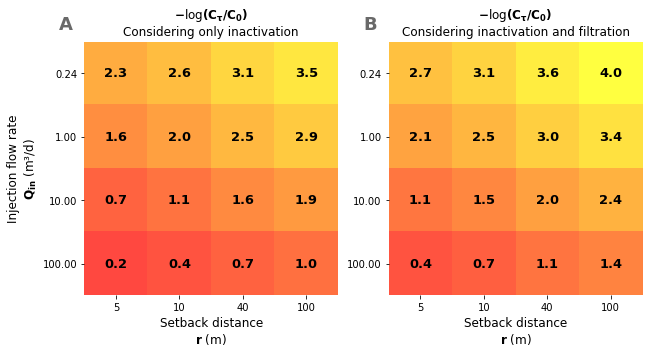

In [16]:
K = 10**-2
H = 20
f = 10
C0 = 1.0
decayRate = 3.5353E-06

Qin_array = np.array([0.24,1.0,10.0,100.])/86400.
rarray = np.array([5.,10.,40.,100.])
Iarray = 10**np.linspace(-5,0,num=100)

Ci = np.zeros([len(rarray),len(Qin_array)])
Ii = np.zeros([len(rarray),len(Qin_array)])
FLi = np.zeros([len(rarray),len(Qin_array)])
I = Iarray

## Predictions 
for qi,Qin in enumerate(Qin_array):
    for ri,r in enumerate(rarray):
        i = findSweet()
        worstC = -np.log10(cBoth()[i])
        worstGradient = Iarray[i]
        worstFlowNumber = flowNumber()[i]
        
        Ci[ri,qi] = worstC
        Ii[ri,qi] = worstGradient
        FLi[ri,qi] = worstFlowNumber

## Pflotran results ONLY DECAY
minI = np.array([0.00046667, 0.0013    , 0.0048    , 0.012     , 0.00046667,
       0.0013    , 0.0048    , 0.012     , 0.00053333, 0.0013    ,
       0.0048    , 0.012     , 0.00056667, 0.0021    , 0.0053    ,
       0.012     ])

minC = np.array([2.2514572 , 2.62298917, 3.14213329, 3.51421485, 1.64182175,
       2.00913676, 2.52461269, 2.89537637, 0.74130696, 1.0754177 ,
       1.55071976, 1.90646243, 0.18705258, 0.39222131, 0.73428991,
       1.00387133])

PFLO_I = np.reshape(minI,Ii.shape).T
PFLO_C = np.reshape(minC,Ci.shape).T

## Build annotations
annot_C = [ [ "None" for y in range(len(Qin_array)) ] for x in range(len(rarray)) ]
annot_I = [ [ "None" for y in range(len(Qin_array)) ] for x in range(len(rarray)) ]

for qi,Qin in enumerate(Qin_array):
    for ri,r in enumerate(rarray):
        pflC,pflI = (0, PFLO_C[ri,qi]) [float(PFLO_C[ri,qi])>0.0] ,PFLO_I[ri,qi]*100
        #zC,zI = (0, Ci[ri,qi]) [float(Ci[ri,qi])>0.0] , Ii[ri,qi]*100
        annot_C[ri][qi] = "{:.1f}".format(pflC)
        annot_I[ri][qi] = "{:.2f}".format(pflI)
        
#########

myLabels={"Title": { 0: r"$\bf{-\log (C_{\tau}/C_0)}$"+"\nConsidering only inactivation",
                     1: r"${\bf I} \times 10^{-2}$ (m/m)",
                     2: r"$\log(\mathcal{F}_L)$"},
          "Y": "Injection flow rate\n$\\bf{Q_{in}}$ (m³/d)",
          "X": "Setback distance\n$\\bf{r}$ (m)"}

fig, axs = plt.subplots(1,2,figsize=(10,5)) 
font = dict(size=12)

ax = axs[0]
im = ax.imshow(PFLO_C.T,cmap="autumn",vmin=0,vmax=4,alpha=0.75)
#cbar = ax.figure.colorbar(im, ax=ax, orientation="horizontal",\
#                         shrink=0.75)

# We want to show all ticks...
ax.set_xticks(np.arange(len(rarray)))
ax.set_yticks(np.arange(len(Qin_array)))
# ... and label them with the respective list entries
ax.set_xticklabels(["{:.0f}".format(i) for i in rarray])
ax.set_yticklabels(["{:.2f}".format(i*86400) for i in Qin_array])

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=0, ha="center",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(Qin_array)):
    for j in range(len(rarray)):
        text = ax.text(j, i, annot_C[j][i],
                       ha="center", va="center", color="k",
                       fontweight="bold",fontsize=13,
                       bbox= dict(facecolor='w', alpha=0,edgecolor='w'))

ax.set_title(myLabels["Title"][0],fontdict=font)              
   
# Turn spines off and create white grid.
for edge, spine in ax.spines.items():
    spine.set_visible(False)
    
ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
ax.tick_params(which="minor", bottom=False, left=False)
ax.set_xlabel(myLabels["X"],fontdict=font)
ax.set_ylabel(myLabels["Y"],fontdict=font)

K = 10**-2
H = 20
f = 10
C0 = 1.0
decayRate = 3.5353E-06
attchRate = 7.2E-06

Qin_array = np.array([0.24,1.0,10.0,100.])/86400.
rarray = np.array([5.,10.,40.,100.])
Iarray = 10**np.linspace(-5,0,num=100)

Ci = np.zeros([len(rarray),len(Qin_array)])
Ii = np.zeros([len(rarray),len(Qin_array)])
FLi = np.zeros([len(rarray),len(Qin_array)])
I = Iarray

## Predictions 
for qi,Qin in enumerate(Qin_array):
    for ri,r in enumerate(rarray):
        i = findSweet2()
        worstC = -np.log10(cTrice()[i])
        worstGradient = Iarray[i]
        worstFlowNumber = flowNumber()[i]
        
        Ci[ri,qi] = worstC
        Ii[ri,qi] = worstGradient
        FLi[ri,qi] = worstFlowNumber

## Pflotran results WITH FILTRATION
minI = np.array([0.0014, 0.0039, 0.0144, 0.036 , 0.0014, 0.0039, 0.0144, 0.036 ,
       0.0016, 0.0039, 0.0144, 0.036 , 0.0017, 0.0063, 0.0159, 0.036 ])

minC = np.array([2.70966103, 3.09070854, 3.61937381, 3.99433636, 2.0934136 ,
       2.47294713, 3.00034689, 3.37487213, 1.13490091, 1.49712873,
       2.00931935, 2.37863042, 0.39427172, 0.66484608, 1.08376174,
       1.41433393])

PFLO_I = np.reshape(minI,Ii.shape).T
PFLO_C = np.reshape(minC,Ci.shape).T

## Build annotations
annot_C = [ [ "None" for y in range(len(Qin_array)) ] for x in range(len(rarray)) ]
annot_I = [ [ "None" for y in range(len(Qin_array)) ] for x in range(len(rarray)) ]

for qi,Qin in enumerate(Qin_array):
    for ri,r in enumerate(rarray):
        pflC,pflI = (0, PFLO_C[ri,qi]) [float(PFLO_C[ri,qi])>0.0] ,PFLO_I[ri,qi]*100
        #zC,zI = (0, Ci[ri,qi]) [float(Ci[ri,qi])>0.0] , Ii[ri,qi]*100
        annot_C[ri][qi] = "{:.1f}".format(pflC)
        annot_I[ri][qi] = "{:.2f}".format(pflI)
        
#########

myLabels={"Title": { 0: r"$\bf{-\log (C_{\tau}/C_0)}$"+"\nConsidering inactivation and filtration",
                     1: r"${\bf I} \times 10^{-2}$ (m/m)",
                     2: r"$\log(\mathcal{F}_L)$"},
          "Y": "",
          "X": "Setback distance\n$\\bf{r}$ (m)"}

#fig, axs = plt.subplots(1,1,figsize=(4,4)) 
font = dict(size=12)

ax = axs[1]
im = ax.imshow(PFLO_C.T,cmap="autumn",vmin=0,vmax=4,alpha=0.75)
#cbar = ax.figure.colorbar(im, ax=ax, orientation="horizontal",\
#                         shrink=0.75)

# We want to show all ticks...
ax.set_xticks(np.arange(len(rarray)))
ax.set_yticks(np.arange(len(Qin_array)))
# ... and label them with the respective list entries
ax.set_xticklabels(["{:.0f}".format(i) for i in rarray])
ax.set_yticklabels(["{:.2f}".format(i*86400) for i in Qin_array])

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=0, ha="center",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(Qin_array)):
    for j in range(len(rarray)):
        text = ax.text(j, i, annot_C[j][i],
                       ha="center", va="center", color="k",
                       fontweight="bold",fontsize=13,
                       bbox= dict(facecolor='w', alpha=0,edgecolor='w'))

ax.set_title(myLabels["Title"][0],fontdict=font)              
   
# Turn spines off and create white grid.
for edge, spine in ax.spines.items():
    spine.set_visible(False)
    
ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
ax.tick_params(which="minor", bottom=False, left=False)
ax.set_xlabel(myLabels["X"],fontdict=font)
ax.set_ylabel(myLabels["Y"],fontdict=font)

#INDICATORS A-B
axs[0].text(-0.10,1.05,"A",transform=axs[0].transAxes,\
              fontsize=18,c='dimgray',fontweight='bold')
axs[1].text(-0.10,1.05,"B",transform=axs[1].transAxes,\
              fontsize=18,c='dimgray',fontweight='bold')

plt.savefig("HeatmapsSimple.png",dpi=300,bbox_inches='tight', pad_inches=0)
plt.show()